In [1]:
import os
RMG_PY_PATH = os.path.expanduser('~/Code/RMG-Py/')
RMG_MODELS_PATH = os.path.expanduser('~/Code/RMG-models/')

In [2]:
import IPython
from IPython.display import display
import sys
import os
import re

sys.path.insert(1,RMG_PY_PATH) # a copy of RMG-Py on the `importer` branch.
from rmgpy.molecule import Molecule
import rmgpy.kinetics
import numpy
import cPickle as pickle
from collections import Counter, defaultdict
from rmgpy.reaction import Reaction
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Reading in the Cantera model of interest

In [4]:
master = 'CombFlame2012/2028-Sarathy' # this should be what was used for '--names=' when generating the .pkl files

In [5]:
# Find and read the chemkin file
with open(os.path.join(RMG_MODELS_PATH, master,'import.sh')) as infile:
    shellscript = infile.read()
reactions_filename = re.search('--reactions\s+(\S+)',shellscript).group(1)
reactions_filepath = os.path.join(RMG_MODELS_PATH,master,reactions_filename)
thermo_filename = re.search('--thermo\s+(\S+)',shellscript).group(1)
thermo_filepath = os.path.join(RMG_MODELS_PATH,master,thermo_filename)
print(reactions_filepath)
print(thermo_filepath)
with open(reactions_filepath) as infile:
    chemkin = infile.readlines()
#for i,line in enumerate(chemkin):
    #print i, line.strip()             # uncomment to print the chemkin model
    
print "".join(chemkin[:4]) # print first 4 lines only

/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/model.txt
/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/thermo.txt
!A comprehensive chemical kinetic combustion model for the four butanol isomers
!S.M. Sarathy, S. Vranckx, K. Yasunaga, M. Mehl, P. O�wald, W.K. Metcalfe,
!C. K. Westbrook, W.J. Pitz, K. Kohse-Hoinghaus, R.X. Fernandes, H.J Curran
!  Accepted Combustion and Flame, Dec 2011



In [6]:
# If you have an up to date cantera, then
#from cantera import ck2cti
# otherwise, do the next two cells
# no, use the hacked version of ck2cti.py in this repo

#%%bash
#curl https://raw.githubusercontent.com/Cantera/cantera/master/interfaces/cython/cantera/ck2cti.py > ck2cti.py

import ck2cti # use the hacked version of ck2cti.py in this repo

In [7]:
parser = ck2cti.Parser()
surfaces = parser.convertMech(inputFile=reactions_filepath,
                              thermoFile=thermo_filepath,
                              transportFile=None,
                              surfaceFile=None,
                              phaseName=None,
                              outName='master.cti',
                              permissive=True)
parser.reactions[0]

oh*<=>oh+hv                                  1.450e+06      0.0           0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.
ch*<=>ch+hv 1.860e+06 0.0 0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.
INFO:root:Skipping unexpected species "hoco" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3cho2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3chcho" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c3h2" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-1" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-2" while reading 

Wrote CTI mechanism file to 'master.cti'.
Mechanism contains 431 species and 2346 reactions.


In [8]:
import rmgpy.rmg
import rmgpy.data
import rmgpy.data.kinetics

In [9]:
dict_path = os.path.join(RMG_MODELS_PATH, master, 'RMG-Py-kinetics-library', 'dictionary.txt')
print "Loading species_dict from",dict_path
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies(dict_path)

Loading species_dict from /Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/RMG-Py-kinetics-library/dictionary.txt


### Creating a dictionary to translate the smiles to the sarathy nicknames

In [10]:
smiles_to_nickname_dict = {}
for species in species_dict.itervalues():
    #print len(species.molecule[0].toSMILES())
    for mol in species.molecule:
        smiles_to_nickname_dict[mol.toSMILES()] = species.label
    
smiles_to_nickname_dict
    

{'C': 'ch4',
 'C#C': 'c2h2',
 'C#CC': 'c3h4-p',
 'C#CC#C': 'c4h2',
 'C#CC=C': 'c4h4',
 'C#CO': 'hccoh',
 'C#C[CH2]': 'c3h3',
 'C#C[C]=C': 'c4h3-i',
 'C#C[O]': 'hcco',
 'C1=CC1': 'cc3h4',
 'C1=CCOC1': 'c4h6o25',
 'C1=COCC1': 'c4h6o23',
 'C1C=COC=1': 'c4h4o',
 'C1CCOC1': 'c4h8o1-4',
 'C1CO1': 'c2h4o1-2',
 'C1COC1': 'c3h6o1-3',
 'C=C': 'c2h4',
 'C=C(C)C': 'ic4h8',
 'C=C(C)C=O': 'ic3h5cho',
 'C=C(C)CO': 'ic4h7oh',
 'C=C(C)COO': 'ic4h7ooh',
 'C=C(C)C[O]': 'ic4h7o',
 'C=C(C)O': 'ic3h5oh',
 'C=C(C)[C]=O': 'ic3h5co',
 'C=C(C)[O]': 'ch3coch2',
 'C=C(O)CC': 'c4h7oh1-2',
 'C=C(O)[CH]C': 'c4h6oh1-32',
 'C=C([O])CC': 'c2h5coch2',
 'C=C=C': 'c3h4-a',
 'C=C=C=C=O': 'h2c4o',
 'C=C=CC': 'c4h612',
 'C=C=O': 'ch2co',
 'C=C=[C]C': 'c4h5-2',
 'C=CC': 'c3h6',
 'C=CC(C)=O': 'c2h3coch3',
 'C=CC(C)O': 'c4h7oh1-3',
 'C=CC(C)[O]': 'c4h7o',
 'C=CC=C': 'c4h6',
 'C=CC=CO': 'c4h5oh-13',
 'C=CC=C[O]': 'ch2chchcho',
 'C=CC=O': 'c2h3cho',
 'C=CCC': 'c4h8-1',
 'C=CCCO': 'c4h7oh1-4',
 'C=CCO': 'c3h5oh',
 'C=CCOO': 'ac3h5

In [11]:
f = open("../../autotst_kinetics.pkl","r")
autotst_kinetics = pickle.load(f)
ooh_reactions = []
for rxn in autotst_kinetics:
    reactants, products = rxn.label.split("_")
    r1, r2 = reactants.split('+')
    p1, p2 = products.split('+')
    if "OO" in [r1, r2, p1, p2] and "[O]O" in [r1, r2, p1, p2]:
        #print [r1, r2, p1, p2]
        ooh_reactions.append(rxn)
        
len(ooh_reactions)

571

In [12]:
sarathy_rxns = []
for r in parser.reactions:
    split_string = str(r).split()
    if not ('ho2' in split_string and 'h2o2' in split_string):
        continue
    reactants = [species_dict[n].molecule[0].toSMILES() for n in r.reactantString.split(' + ')]
    products = [species_dict[n].molecule[0].toSMILES() for n in r.productString.split(' + ')]
    import itertools
    joined_reactant_orders = ['+'.join(order) for order in itertools.permutations(reactants)]
    joined_product_orders = ['+'.join(order) for order in itertools.permutations(products)]
    possible_labels = ['_'.join((joined_r, joined_p)) for joined_r in joined_reactant_orders for joined_p in joined_product_orders]
    
    
    for reaction in ooh_reactions:
        ooh_reactants, ooh_products = reaction.label.split("_")
        r1, r2 = ooh_reactants.split("+")
        p1, p2 = ooh_products.split("+")
        ooh_smiles = [r1, r2, p1, p2]
        
        inchikey_to_smiles_dict = {}
        for smiles in ooh_smiles:
            inchikey_to_smiles_dict[Molecule(SMILES=smiles).toInChIKey()] = smiles
        
    
        
        if reaction.label in possible_labels:
            for reactant in reaction.reactants:
                inchi_key = reactant.label.split("-u")[0]
                if not reactant.label in smiles_to_nickname_dict.itervalues():
                    reactant.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    reactant.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            for product in reaction.products:
                inchi_key = product.label.split("-u")[0]
                if not product.label in smiles_to_nickname_dict.itervalues():
                    product.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    product.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            
            sarathy_rxns.append([r, reaction, reaction.toChemkin(), reaction.toCantera()])
        
df = pd.DataFrame(sarathy_rxns)

df.columns = ["Sarathy Reaction", "AutoTST Reaction", "AutoTST Reaction - Chemkin" , "AutoTST - Cantera"]

df

,Sarathy Reaction,AutoTST Reaction,AutoTST Reaction - Chemkin,AutoTST - Cantera
0,h2o2 + h <=> h2 + ho2,h2o2 + h <=> h2 + ho2,"! Fitted to 59 data points; dA = *|/ 1.57377, ...",h + h2o2 <=> h2 + ho2
1,ch2o + ho2 <=> hco + h2o2,ch2o + ho2 <=> h2o2 + hco,"! Fitted to 59 data points; dA = *|/ 2.04573, ...",ch2o + ho2 <=> h2o2 + hco
2,ch3oh + ho2 <=> ch2oh + h2o2,ho2 + ch3oh <=> ch2oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.49501, ...",ch3oh + ho2 <=> ch2oh + h2o2
3,c2h6 + ho2 <=> c2h5 + h2o2,c2h6 + ho2 <=> c2h5 + h2o2,"! Fitted to 59 data points; dA = *|/ 1.37627, ...",c2h6 + ho2 <=> c2h5 + h2o2
4,c2h4o1-2 + ho2 <=> c2h3o1-2 + h2o2,c2h4o1-2 + ho2 <=> h2o2 + c2h3o1-2,"! Fitted to 59 data points; dA = *|/ 1.07588, ...",c2h4o1-2 + ho2 <=> c2h3o1-2 + h2o2
5,ch3cho + ho2 <=> ch3co + h2o2,ch3cho + ho2 <=> h2o2 + ch3co,"! Fitted to 59 data points; dA = *|/ 1.59886, ...",ch3cho + ho2 <=> ch3co + h2o2
6,h2o2 + ch3co3 <=> ho2 + ch3co3h,ch3co3 + h2o2 <=> ho2 + ch3co3h,"! Fitted to 59 data points; dA = *|/ 1.11476, ...",ch3co3 + h2o2 <=> ch3co3h + ho2
7,c2h5oh + ho2 <=> sc2h4oh + h2o2,ho2 + c2h5oh <=> sc2h4oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.28209, ...",c2h5oh + ho2 <=> h2o2 + sc2h4oh
8,c2h5oh + ho2 <=> pc2h4oh + h2o2,c2h5oh + ho2 <=> pc2h4oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.17747, ...",c2h5oh + ho2 <=> h2o2 + pc2h4oh
9,c2h3cho + ho2 <=> c2h3co + h2o2,c2h3cho + ho2 <=> c2h3co + h2o2,"! Fitted to 59 data points; dA = *|/ 1.91111, ...",c2h3cho + ho2 <=> c2h3co + h2o2


In [13]:
print type(df.iloc[:,0])

<class 'pandas.core.series.Series'>


In [14]:

chemkin_string = df.iloc[0,2]
chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
chemkin_string
cantera_reaction, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
cti_string = str(cantera_reaction)
cantera_reaction.to_cti()

"reaction('h2o2 + h <=> h2 + ho2', [1.651000e+02, 3.267, 1.0])"

In [15]:
parser.energy_units = 'kcal/mol'
reactions_by_cti_string = {}
for entry in zip(df.iloc[:,1], df.iloc[:,2]):
    reaction, chemkin_string = entry
    kinetics = reaction.kinetics
    chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
    chemkin_string
    cantera_reaction, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
    cti_string = str(cantera_reaction)
    reactions_by_cti_string[cti_string] = (reaction, chemkin_string, cantera_reaction)
    
print len(reactions_by_cti_string)
print '\n'.join(sorted(reactions_by_cti_string.keys()))

55
c2h3cho + ho2 <=> c2h3co + h2o2
c2h4o1-2 + ho2 <=> h2o2 + c2h3o1-2
c2h5cho + ho2 <=> c2h5co + h2o2
c2h5coch3 + ho2 <=> c2h5coch2 + h2o2
c2h5oh + ho2 <=> pc2h4oh + h2o2
c2h6 + ho2 <=> c2h5 + h2o2
c3h6 + ho2 <=> h2o2 + c3h5-a
c3h8 + ho2 <=> h2o2 + ic3h7
c3h8 + ho2 <=> h2o2 + nc3h7
c4h10 + ho2 <=> pc4h9 + h2o2
c4h8oh-4o2 + h2o2 <=> c4h8oh-4o2h + ho2
ch2o + ho2 <=> h2o2 + hco
ch3cho + ho2 <=> h2o2 + ch3co
ch3co3 + h2o2 <=> ho2 + ch3co3h
ch3och3 + ho2 <=> h2o2 + ch3och2
ch3ocho + ho2 <=> h2o2 + ch3oco
h2o2 + c4h8oh-2o2 <=> ho2 + c4h8oh-2o2h
h2o2 + h <=> h2 + ho2
h2o2 + ic4h8oh-1o2 <=> ho2 + ic4h8oh-1o2h
h2o2 + ic4h8oh-2o2 <=> ho2 + ic4h8oh-2o2h
h2o2 + sc4h8oh-3o2 <=> ho2 + sc4h8oh-3o2h
h2o2 + sc4h8oh-mo2 <=> sc4h8oh-mo2h + ho2
h2o2 + sc4h9o2 <=> sc4h9o2h + ho2
ho2 + c2h5coch3 <=> ch2ch2coch3 + h2o2
ho2 + c2h5oh <=> sc2h4oh + h2o2
ho2 + c4h10 <=> sc4h9 + h2o2
ho2 + c4h7oh1-2 <=> h2o2 + c4h6oh1-32
ho2 + c4h8-1 <=> h2o2 + c4h71-4
ho2 + ch3ocho <=> ch2ocho + h2o2
ho2 + ch3oh <=> ch2oh + h2o2

In [16]:
import textwrap
original_reactions = list()
alternatives_rates = defaultdict(list)
for i, r in enumerate(parser.reactions):
    original_reactions.append(r)
    assert original_reactions[i] == parser.reactions[i]
    
    if r in list(df.iloc[:,0]):
        #print df[r == df.iloc[:,0]]
        #print r
        #print reactions_by_cti_string[str(r)]
        _, rmg_reaction, kinetics_options, ct_version_of_rmg_kinetics = df[r == df.iloc[:,0]].values[0]
        # we just want the rmg_reaction
        
        #rmg_reaction.kinetics = k
        chemkin_string = rmg_reaction.toChemkin()
        chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
        r2, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
        # r2 is the new replacement reaction

        """assert r2.reactants == r.reactants
        assert r2.products == r.products
        assert r2.reversible == r.reversible
        assert r2.duplicate == r.duplicate
        assert r2.fwdOrders == r.fwdOrders
        """
        r2.comment = r.comment
        r2.comment += '\n \nSUBSTITUTION: The following reaction was originally\n{}\n'.format(r.to_cti())
        #model_list = textwrap.fill(', '.join(models), break_on_hyphens=False, break_long_words=False)
        r2.comment += 'But has been replaced with the following as seen in AutoTST'

        alternatives_rates[i].append(r2)

        print
        print '\n'.join(['# '+c for c in r2.comment.split('\n') if c])
        print r2.to_cti()




# ref: ellingson j. phys. chem. (2007) 111, (51), 13554-13566
#  
# SUBSTITUTION: The following reaction was originally
# reaction('h2o2 + h <=> h2 + ho2', [2.150000e+10, 1.0, 6000.0])
# But has been replaced with the following as seen in AutoTST
reaction('h2o2 + h <=> h2 + ho2', [1.651000e+02, 3.267, (1.016, 'kcal/mol')])

# wkm 01/11/10
# !ref:Fit to Hidaka et al. and Jemi-Alade,A.A.
# ch2o+ho2<=>hco+h2o2 7.100e-03 4.517 6.580e+03
# ref:J. Phys. Chem. A 109, 12027-12035, 2005
#  
# SUBSTITUTION: The following reaction was originally
# reaction('ch2o + ho2 <=> hco + h2o2', [1.880000e+04, 2.7, 11520.0])
# But has been replaced with the following as seen in AutoTST
reaction('ch2o + ho2 <=> h2o2 + hco', [4.257000e-06, 5.203, (5.098, 'kcal/mol')])

# ref:curran estimate
#  
# SUBSTITUTION: The following reaction was originally
# reaction('ch3oh + ho2 <=> ch2oh + h2o2', [1.080000e+04, 2.55, 10530.0])
# But has been replaced with the following as seen in AutoTST
reaction('ho2 + ch3oh <=> c

In [17]:
print "original reactions", len(parser.reactions)
print "reactions to change", len(alternatives_rates)
c = Counter(map(len,alternatives_rates.values()))
print "substitutions", sorted(c.items())
print "total variations", sum(map(len,alternatives_rates.values()))

original reactions 2346
reactions to change 55
substitutions [(1, 55)]
total variations 55


In [18]:
# this creates ~1281 cantera files, each with a single variation
outdir = './cantera_sub_models/sarathy/'
os.path.exists(outdir) or os.mkdir(outdir)
for f in os.listdir(outdir):
    os.unlink(os.path.join(outdir, f))

In [19]:
parser.writeCTI(outName=os.path.join(outdir,'master.0.0.cti'))
for i, options in alternatives_rates.iteritems():
    for j, replacement in enumerate(options):
        output_filename = 'master.{}.{}.cti'.format(i+1,j+1)
        parser.reactions[i] = replacement
        ## save the file!
        header = ["####################################################",
                  "##  Reaction {:2d} has been replaced with option {:2d}  ##".format(i+1,j+1),
                  "####################################################"]
        print "saving", output_filename
        parser.writeCTI(header=header, outName=os.path.join(outdir,output_filename))
        # restore original
        parser.reactions[i] = original_reactions[i]

saving master.2177.1.cti
saving master.263.1.cti
saving master.1645.1.cti
saving master.787.1.cti
saving master.788.1.cti
saving master.22.1.cti
saving master.410.1.cti
saving master.1564.1.cti
saving master.1565.1.cti
saving master.1566.1.cti
saving master.1567.1.cti
saving master.1568.1.cti
saving master.1953.1.cti
saving master.1187.1.cti
saving master.421.1.cti
saving master.2247.1.cti
saving master.552.1.cti
saving master.1194.1.cti
saving master.1195.1.cti
saving master.1196.1.cti
saving master.1325.1.cti
saving master.1326.1.cti
saving master.435.1.cti
saving master.1081.1.cti
saving master.2106.1.cti
saving master.1211.1.cti
saving master.1473.1.cti
saving master.196.1.cti
saving master.2245.1.cti
saving master.2246.1.cti
saving master.839.1.cti
saving master.2248.1.cti
saving master.1482.1.cti
saving master.77.1.cti
saving master.1955.1.cti
saving master.1233.1.cti
saving master.2105.1.cti
saving master.473.1.cti
saving master.474.1.cti
saving master.1758.1.cti
saving master.2

### Using the following function to get the ignition delay at a given temperature and pressure

In [20]:
import os, sys
from collections import defaultdict
import cantera as ct
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

def get_ignition_delay(cantera_file_path, temperature , pressure, stoichiometry=1.0, plot=False, isomer='n'):
    """
    Get the ignition delay at temperature (K) and pressure (bar) and stochiometry (phi),
    for the butanol isomer (n,s,t,i)
    """
    try:
        ct.suppress_thermo_warnings(True)
    except AttributeError:
        print("Sorry about the warnings...")
    gas = ct.Solution(cantera_file_path)
    assert isomer in ['n','s','t','i'], "Expecting isomer n,s,t, or i not {}".format(isomer)
    oxygen_mole = 1.0
    argon_mole = 96./4.*oxygen_mole
    butanol_mole = stoichiometry * oxygen_mole/6.
    X_string = isomer + 'c4h9oh:{0}, o2:{1}, ar:{2}'.format(butanol_mole, oxygen_mole, argon_mole)
    gas.TPX = temperature, pressure*1e5, X_string
    reactor=ct.IdealGasReactor(gas)
    reactor_network=ct.ReactorNet([reactor])
    time=0.0
    end_time=1000e-3
    times=[]
    concentrations=[]
    
    pressures=[]
    temperatures=[]
    print_data = True
    while time < end_time:
        time=reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        reactor_network.step(end_time)
    print("reached end time {0:.4f} ms in {1} steps ". format(times[-1]*1e3, len(times)))
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    
    dTdt = (temperatures[1:] - temperatures[:-1]) / (times[1:] - times[:-1])
    
    if plot:
        plt.subplot(2,1,1)
        plt.plot(times,temperatures)
        plt.subplot(2,1,2)
        plt.plot(times[1:], dTdt)
        plt.show()
        
    step_with_fastest_T_rise = dTdt.argmax()
    if step_with_fastest_T_rise > 1 and step_with_fastest_T_rise < len(times)-2:
        ignition_time_ms = 1e3 * times[step_with_fastest_T_rise]
        print("At {0} K {1} bar, ignition delay time is {2} ms for {3}-butanol".format(temperature,pressure,ignition_time_ms,isomer))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition is detected for {2}-butanol" .format(temperature, pressure, isomer))
        return np.infty

In [24]:
ignition_delays = []
ignition_temps = np.arange(500, 2050, 100)
dff = pd.DataFrame(index=ignition_temps)
dff.index = ignition_temps

if not os.path.exists("./ignition_delay_sarathy.pkl"):
    for cantera_file in os.listdir("./cantera_sub_models/sarathy/"):
        identifier = cantera_file.split(".")[1]
        print cantera_file
        delays = []
        for ignition_temp in ignition_temps:
            delay = get_ignition_delay(os.path.join("./cantera_sub_models/sarathy/", cantera_file),
                       temperature=ignition_temp, 
                       pressure=1, 
                       stoichiometry=1.0, 
                       plot=False)

            delays.append(delay)
        test = pd.DataFrame(delays)
        test.columns = [identifier]
        test.index = ignition_temps
        dff = pd.concat([dff, test], axis=1)
    f=open("ignition_delay_sarathy.pkl", "w")
    pickle.dump(dff, f)
else:
    f=open("ignition_delay_sarathy.pkl", "r")
    dff = pickle.load(f)
    
dff

,0,1081,1148,1150,1187,1194,1195,1196,1211,1233,...,435,473,474,502,503,552,77,787,788,839
500,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
600,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
700,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
800,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
900,670.467553,670.467417,670.467831,670.468806,680.606952,670.832683,671.200620,671.324240,670.468345,670.467606,...,670.468503,670.467357,670.467492,670.488447,670.473905,673.258511,709.866672,670.469255,670.473988,670.488853
1000,90.879062,90.879086,90.879143,90.879449,91.160536,90.892450,90.907379,90.906926,90.879107,90.879132,...,90.879378,90.879095,90.878946,90.893031,90.885737,91.389379,99.502735,90.879903,90.881450,90.885309
1100,17.104575,17.104659,17.104735,17.104582,17.116367,17.105407,17.106058,17.105963,17.104500,17.104725,...,17.104675,17.104663,17.104659,17.108155,17.106842,17.186725,18.601763,17.104830,17.104883,17.106125
1200,4.071111,4.071082,4.071115,4.071135,4.072050,4.071068,4.071238,4.071137,4.071099,4.071105,...,4.071003,4.071065,4.070886,4.071648,4.071464,4.081045,4.282712,4.071130,4.071047,4.071320
1300,1.256287,1.256253,1.256185,1.256314,1.256495,1.256238,1.256301,1.256317,1.256302,1.256269,...,1.256207,1.256270,1.256292,1.256372,1.256364,1.257613,1.292327,1.256294,1.256276,1.256324
1400,0.479214,0.479215,0.479126,0.479105,0.479193,0.479214,0.479243,0.479158,0.479166,0.479212,...,0.479175,0.479207,0.479206,0.479206,0.479211,0.479400,0.487137,0.479200,0.479225,0.479199


In [25]:
(((dff.T - dff.T.mean()) / dff.T.std()) > 2.7).T.any()

0       False
1081    False
1148    False
1150    False
1187    False
1194    False
1195    False
1196    False
1211    False
1233    False
124     False
1325    False
1326    False
1400    False
1401    False
1473    False
1482    False
1564    False
1565    False
1566    False
1567     True
1568    False
1645    False
1758    False
1789    False
1790    False
1791    False
1953    False
1955    False
196     False
2105    False
2106    False
2107    False
2177    False
22      False
2245    False
2246    False
2247    False
2248    False
237     False
252     False
263     False
369     False
370     False
410     False
421     False
435     False
473     False
474     False
502     False
503     False
552     False
77       True
787     False
788     False
839     False
dtype: bool

The reactions that we want to look at are reactions numbers `77` and `1567` because their rates were statistically significant (p=0.95) when our reactions into the Sarathy model 

In [26]:
alternative_rate = alternatives_rates[1567][0]

In [27]:
r1 = species_dict[str(alternative_rate.reactants[0][1].label)]
r2 = species_dict[str(alternative_rate.reactants[1][1].label)]
p1 = species_dict[str(alternative_rate.products[0][1].label)]
p2 = species_dict[str(alternative_rate.products[1][1].label)]

In [28]:
rxn_of_interest = Reaction(reactants=[r1, r2], products=[p1, p2])
rxn_of_interest

### Not sure why this rate is null, but we'll look into this later.

In [29]:
f = open("../reference_files/importerKinetics.pkl", "r")
importer_kinetics = pickle.load(f)
importer_kinetics = pd.DataFrame(importer_kinetics)

In [30]:
for i, reaction in enumerate(importer_kinetics.columns):
    if reaction.isIsomorphic(rxn_of_interest):
        rxn_kinetics = importer_kinetics.iloc[:,i].dropna()


In [31]:
for i, rxn in enumerate(df["AutoTST Reaction"]):
    if rxn.isIsomorphic(rxn_of_interest):
        rxn_kin = rxn.kinetics
        
        label = rxn.label   
    
rxn_kinetics['AutoTST'] = rxn_kin
rxn_kinetics

CombFlame2012/2028-Sarathy    Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, ...
CombFlame2013/1939-Cai        Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, ...
CombFlame2014/657-Jin         Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, ...
PCI2013/289-Dagaut            Arrhenius(A=(37710,'cm^3/(mol*s)'), n=2, Ea=(1...
PCI2017/087-Tran              Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, ...
AutoTST                       Arrhenius(A=(0.0574127,'cm^3/(mol*s)'), n=3.95...
Name: nc4h9oh + ho2 <=> pc4h9o + h2o2, dtype: object

0


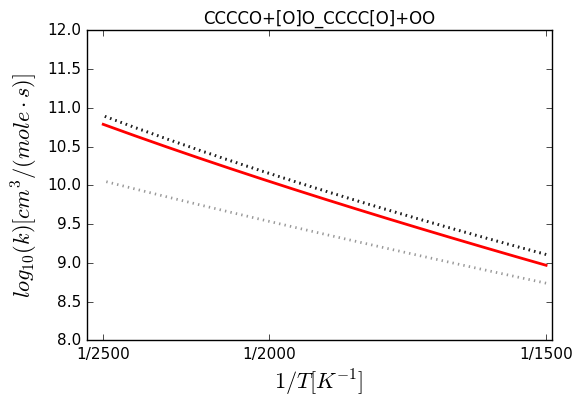

In [32]:
inverseTemps = np.linspace(1000./1500., 1000./2500., 15)
Temps = 1000./inverseTemps

comparisonPressure = 1e5 # Pa

# make a copy and leave the original so we can try this cell several times

fig, ax = plt.subplots()
for index in rxn_kinetics.index:
    logk = []
    logkAutoTST = []
    kinetics = rxn_kinetics[index]

    if index == 'AutoTST':
        
        for Temp in Temps:
            k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
            logkAutoTST.append(np.log10(k) + 6)

        plt.plot(inverseTemps, logkAutoTST, '-r', linewidth=2)
    else:
        for Temp in Temps:
            k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
            logk.append(np.log10(k) + 6)
        plt.plot(inverseTemps, logk, ':k', linewidth=2, alpha=0.4)
plt.xlabel("$1/T [K^{-1}]$", fontsize=16)
plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)

Tticks = [1500, 2000, 2500]
ax.set_xticks([1000./T for T in Tticks])
ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.title(label)
plt.xlim([0.39,0.67])

#plt.ylim([6,13])
# the following will EXPAND the limits to at least (6,13) but not shrink them
plt.ylim(min(ax.get_ylim()[0], 8), max(ax.get_ylim()[1], 12))
saveString = str(label) + '.pdf'
#plt.savefig(saveString)
print str(j)
plt.show() 


In [33]:
for index in rxn_kinetics.index:
    print index
    print rxn_kinetics[index]
    print 


CombFlame2012/2028-Sarathy
Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, Ea=(10530,'cal/mol'), T0=(1,'K'))

CombFlame2013/1939-Cai
Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, Ea=(10530,'cal/mol'), T0=(1,'K'))

CombFlame2014/657-Jin
Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, Ea=(10530,'cal/mol'), T0=(1,'K'))

PCI2013/289-Dagaut
Arrhenius(A=(37710,'cm^3/(mol*s)'), n=2, Ea=(15025.6,'cal/mol'), T0=(1,'K'))

PCI2017/087-Tran
Arrhenius(A=(6.47e-07,'cm^3/(mol*s)'), n=5.3, Ea=(10530,'cal/mol'), T0=(1,'K'))

AutoTST
Arrhenius(A=(0.0574127,'cm^3/(mol*s)'), n=3.9559, Ea=(67.5659,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06209, dn = +|- 0.00790624, dEa = +|- 0.0434923 kJ/mol""")



# Now, doing all of this for heptane

In [3]:
master = 'n-Heptane' # this should be what was used for '--names=' when generating the .pkl files

In [4]:
# Find and read the chemkin file
with open(os.path.join(RMG_MODELS_PATH, master,'import.sh')) as infile:
    shellscript = infile.read()
reactions_filename = re.search('--reactions\s+(\S+)',shellscript).group(1)
reactions_filepath = os.path.join(RMG_MODELS_PATH,master,reactions_filename)
thermo_filename = re.search('--thermo\s+(\S+)',shellscript).group(1)
thermo_filepath = os.path.join(RMG_MODELS_PATH,master,thermo_filename)
print(reactions_filepath)
print(thermo_filepath)
with open(reactions_filepath) as infile:
    chemkin = infile.readlines()
#for i,line in enumerate(chemkin):
    #print i, line.strip()             # uncomment to print the chemkin model
    
print "".join(chemkin[:4]) # print first 4 lines only

/Users/nathan/Code/RMG-models/n-Heptane/nc7_ver3.1_mech.txt
/Users/nathan/Code/RMG-models/n-Heptane/n_heptane_v3.1_therm.dat
!n-heptane mechanism ver. 3.1 2012-03-30
!M. Mehl, W. J. Pitz, C. K. Westbrook and H. J. Curran, "Kinetic Modeling of Gasoline Surrogate Components and Mixtures under Engine Conditions," Proc. Combust. Inst.  33 (1) (2011) 193-200.
!LLNL-MI-536391
!March 2012: Multiplied the A-factors of the molecular elimination of HO2 from heptyl-O2 by a factor of 2. The previous version reported lower values doe to a clerical error in the uploaded file.



In [5]:
dict_path = os.path.join(RMG_MODELS_PATH, master, 'RMG-Py-kinetics-library', 'dictionary.txt')
print "Loading species_dict from",dict_path
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies(dict_path)

Loading species_dict from /Users/nathan/Code/RMG-models/n-Heptane/RMG-Py-kinetics-library/dictionary.txt


AttributeError: 'module' object has no attribute 'kinetics'

In [37]:
smiles_to_nickname_dict = {}
for species in species_dict.itervalues():
    #print len(species.molecule[0].toSMILES())
    for mol in species.molecule:
        smiles_to_nickname_dict[mol.toSMILES()] = species.label
    
smiles_to_nickname_dict
    

{'C': 'C',
 'C#C': 'C2H2',
 'C#CC': 'C3H4-P',
 'C#CO': 'HCCOH',
 'C#C[CH2]': 'C3H3',
 'C#C[O]': 'HCCO',
 'C1CCOC1': 'C4H8O1-4',
 'C1CCOCC1': 'C5H10O1-5',
 'C1CO1': 'C2H4O1-2',
 'C1COC1': 'C3H6O1-3',
 'C=C': 'C2H4',
 'C=C(C)C': 'IC4H8',
 'C=C(C)C=O': 'IC3H5CHO',
 'C=C(C)CO': 'IC4H7OH',
 'C=C(C)COO': 'IC4H7OOH',
 'C=C(C)C[O]': 'IC4H7O',
 'C=C(C)O': 'IC3H5OH',
 'C=C(C)[C]=O': 'IC3H5CO',
 'C=C(C)[O]': 'CH3COCH2',
 'C=C([O])CC': 'C2H5COCH2',
 'C=C([O])CCC': 'NC3H7COCH2',
 'C=C([O])CCCC': 'NC4H9COCH2',
 'C=C=C': 'C3H4-A',
 'C=C=O': 'CH2CO',
 'C=CC': 'C3H6',
 'C=CC(=O)C(CC)OO': 'NC6D1KET34',
 'C=CC(=O)CC': 'C2H5COC2H3',
 'C=CC(=O)CC(C)OO': 'NC6D1KET35',
 'C=CC(=O)CCC': 'C2H3COC3H7',
 'C=CC(=O)CCCOO': 'NC6D1KET36',
 'C=CC(=O)[CH]C': 'SC2H4COC2H3',
 'C=CC(C)=O': 'C2H3COCH3',
 'C=CC(C)[O]': 'C4H7O',
 'C=CC(CC(C)=O)OO': 'NC6D1KET53',
 'C=CC(CC(C)OO)O[O]': 'C6H101OOH5-3O2',
 'C=CC(CC(C)O[O])OO': 'C6H101OOH3-5O2',
 'C=CC(CCC)O[O]': 'C6H111O2-3',
 'C=CC(CCC=O)OO': 'NC6D1KET63',
 'C=CC(CCCOO)O[O]': '

In [39]:
f = open("../../autotst_kinetics.pkl","r")
autotst_kinetics = pickle.load(f)
ooh_reactions = []
for rxn in autotst_kinetics:
    reactants, products = rxn.label.split("_")
    r1, r2 = reactants.split('+')
    p1, p2 = products.split('+')
    if "OO" in [r1, r2, p1, p2] and "[O]O" in [r1, r2, p1, p2]:
        #print [r1, r2, p1, p2]
        ooh_reactions.append(rxn)
        
len(ooh_reactions)

571

In [40]:
parser = ck2cti.Parser()
surfaces = parser.convertMech(inputFile=reactions_filepath,
                              thermoFile=thermo_filepath,
                              transportFile=None,
                              surfaceFile=None,
                              phaseName=None,
                              outName='master.cti',
                              permissive=True)
parser.reactions[0]

INFO:root:Skipping unexpected species "HOCO" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3CHO2H" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3CHCHO" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C3H51-2V3OOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C3H52-1V3OOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "IC5H12" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "AC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "BC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "DC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "AC5H10" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "BC5H10" while reading thermodynami

Wrote CTI mechanism file to 'master.cti'.
Mechanism contains 654 species and 4846 reactions.


In [41]:
heptane_rxns = []
for r in parser.reactions:
    split_string = str(r).split()
    if not (smiles_to_nickname_dict["OO"] in split_string and smiles_to_nickname_dict["[O]O"] in split_string):
        continue
    reactants = [species_dict[n].molecule[0].toSMILES() for n in r.reactantString.split(' + ')]
    products = [species_dict[n].molecule[0].toSMILES() for n in r.productString.split(' + ')]
    import itertools
    joined_reactant_orders = ['+'.join(order) for order in itertools.permutations(reactants)]
    joined_product_orders = ['+'.join(order) for order in itertools.permutations(products)]
    possible_labels = ['_'.join((joined_r, joined_p)) for joined_r in joined_reactant_orders for joined_p in joined_product_orders]
    
    
    for reaction in ooh_reactions:
        ooh_reactants, ooh_products = reaction.label.split("_")
        r1, r2 = ooh_reactants.split("+")
        p1, p2 = ooh_products.split("+")
        ooh_smiles = [r1, r2, p1, p2]
        
        inchikey_to_smiles_dict = {}
        for smiles in ooh_smiles:
            inchikey_to_smiles_dict[Molecule(SMILES=smiles).toInChIKey()] = smiles
        
    
        
        if reaction.label in possible_labels:
            for reactant in reaction.reactants:
                inchi_key = reactant.label.split("-u")[0]
                if not reactant.label in smiles_to_nickname_dict.itervalues():
                    reactant.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    reactant.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            for product in reaction.products:
                inchi_key = product.label.split("-u")[0]
                if not product.label in smiles_to_nickname_dict.itervalues():
                    product.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    product.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            
            heptane_rxns.append([r, reaction, reaction.toChemkin(), reaction.toCantera()])
        
df = pd.DataFrame(heptane_rxns)

df.columns = ["Heptane Reaction", "AutoTST Reaction", "AutoTST Reaction - Chemkin" , "AutoTST - Cantera"]

df

,Heptane Reaction,AutoTST Reaction,AutoTST Reaction - Chemkin,AutoTST - Cantera
0,H2O2 + H -> H2 + HO2,H2O2 + H <=> H2 + HO2,"! Fitted to 59 data points; dA = *|/ 1.57377, ...",H + H2O2 <=> H2 + HO2
1,CH2O + HO2 -> HCO + H2O2,CH2O + HO2 <=> H2O2 + HCO,"! Fitted to 59 data points; dA = *|/ 2.04573, ...",CH2O + HO2 <=> H2O2 + HCO
2,HCO + H2O2 -> CH2O + HO2,HCO + H2O2 <=> CH2O + HO2,"! Fitted to 59 data points; dA = *|/ 1.80424, ...",H2O2 + HCO <=> CH2O + HO2
3,HOCHO + HO2 -> OCHO + H2O2,HO2 + HOCHO <=> OCHO + H2O2,"! Fitted to 59 data points; dA = *|/ 1.02165, ...",HO2 + HOCHO <=> H2O2 + OCHO
4,CH3OH + HO2 -> CH2OH + H2O2,HO2 + CH3OH <=> CH2OH + H2O2,"! Fitted to 59 data points; dA = *|/ 1.49501, ...",CH3OH + HO2 <=> CH2OH + H2O2
5,CH2OH + H2O2 -> CH3OH + HO2,CH2OH + H2O2 <=> CH3OH + HO2,"! Fitted to 59 data points; dA = *|/ 1.11474, ...",CH2OH + H2O2 <=> CH3OH + HO2
6,C2H6 + HO2 -> C2H5 + H2O2,C2H6 + HO2 <=> C2H5 + H2O2,"! Fitted to 59 data points; dA = *|/ 1.37627, ...",C2H6 + HO2 <=> C2H5 + H2O2
7,C2H5 + H2O2 -> C2H6 + HO2,C2H5 + H2O2 <=> C2H6 + HO2,"! Fitted to 59 data points; dA = *|/ 1.12702, ...",C2H5 + H2O2 <=> C2H6 + HO2
8,C2H4O1-2 + HO2 -> C2H3O1-2 + H2O2,C2H4O1-2 + HO2 <=> H2O2 + C2H3O1-2,"! Fitted to 59 data points; dA = *|/ 1.07588, ...",C2H4O1-2 + HO2 <=> C2H3O1-2 + H2O2
9,CH3CHO + HO2 -> CH3CO + H2O2,CH3CHO + HO2 <=> H2O2 + CH3CO,"! Fitted to 59 data points; dA = *|/ 1.59886, ...",CH3CHO + HO2 <=> CH3CO + H2O2


In [42]:
parser.energy_units = 'kcal/mol'
reactions_by_cti_string = {}
for entry in zip(df.iloc[:,1], df.iloc[:,2]):
    reaction, chemkin_string = entry
    kinetics = reaction.kinetics
    chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
    chemkin_string
    cantera_reaction, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
    cti_string = str(cantera_reaction)
    reactions_by_cti_string[cti_string] = (reaction, chemkin_string, cantera_reaction)
    
print len(reactions_by_cti_string)
print '\n'.join(sorted(reactions_by_cti_string.keys()))

117
AC3H5CHO + HO2 <=> AC3H5CO + H2O2
AC3H5CHO + HO2 <=> C2H3CHCHO + H2O2
AC3H5CO + H2O2 <=> AC3H5CHO + HO2
C2H4O1-2 + HO2 <=> H2O2 + C2H3O1-2
C2H5 + H2O2 <=> C2H6 + HO2
C2H5CHO + HO2 <=> C2H5CO + H2O2
C2H5COC2H3 + HO2 <=> H2O2 + PC2H4COC2H3
C2H5COC2H3 + HO2 <=> H2O2 + SC2H4COC2H3
C2H5COC2H5 + HO2 <=> C2H5COC2H4P + H2O2
C2H5COCH3 + HO2 <=> C2H5COCH2 + H2O2
C2H5OH + HO2 <=> PC2H4OH + H2O2
C2H6 + HO2 <=> C2H5 + H2O2
C3H5-A + H2O2 <=> C3H6 + HO2
C3H6 + HO2 <=> H2O2 + C3H5-A
C3H8 + HO2 <=> H2O2 + IC3H7
C3H8 + HO2 <=> H2O2 + NC3H7
C4H10 + HO2 <=> PC4H9 + H2O2
C4H6CHO1-43 + H2O2 <=> C4H7CHO1-4 + HO2
C4H7CHO1-4 + HO2 <=> H2O2 + C4H7CO1-4
C4H8COCH3-2 + H2O2 <=> NC4H9COCH3 + HO2
C4H8COCH3-3 + H2O2 <=> NC4H9COCH3 + HO2
C5H10-1 + HO2 <=> C5H91-5 + H2O2
C5H10-2 + HO2 <=> H2O2 + C5H91-3
C5H10-2 + HO2 <=> H2O2 + C5H92-5
C5H10CHO-1 + H2O2 <=> HO2 + NC5H11CHO
C5H10CHO-2 + H2O2 <=> HO2 + NC5H11CHO
C5H10CHO-3 + H2O2 <=> NC5H11CHO + HO2
C5H10CHO-4 + H2O2 <=> HO2 + NC5H11CHO
C5H11-2 + H2O2 <=> NC5H12 + HO

In [43]:
import textwrap
original_reactions = list()
alternatives_rates = defaultdict(list)
for i, r in enumerate(parser.reactions):
    original_reactions.append(r)
    assert original_reactions[i] == parser.reactions[i]
    
    if r in list(df.iloc[:,0]):
        #print df[r == df.iloc[:,0]]
        #print r
        #print reactions_by_cti_string[str(r)]
        _, rmg_reaction, kinetics_options, ct_version_of_rmg_kinetics = df[r == df.iloc[:,0]].values[0]
        # we just want the rmg_reaction
        
        #rmg_reaction.kinetics = k
        chemkin_string = rmg_reaction.toChemkin()
        chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
        r2, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
        # r2 is the new replacement reaction

        """assert r2.reactants == r.reactants
        assert r2.products == r.products
        assert r2.reversible == r.reversible
        assert r2.duplicate == r.duplicate
        assert r2.fwdOrders == r.fwdOrders
        """
        r2.comment = r.comment
        r2.comment += '\n \nSUBSTITUTION: The following reaction was originally\n{}\n'.format(r.to_cti())
        #model_list = textwrap.fill(', '.join(models), break_on_hyphens=False, break_long_words=False)
        r2.comment += 'But has been replaced with the following as seen in AutoTST'

        alternatives_rates[i].append(r2)

        print
        print '\n'.join(['# '+c for c in r2.comment.split('\n') if c])
        print r2.to_cti()




#  
# SUBSTITUTION: The following reaction was originally
# reaction('H2O2 + H => H2 + HO2', [2.150000e+10, 1.0, 6000.0])
# But has been replaced with the following as seen in AutoTST
reaction('H2O2 + H <=> H2 + HO2', [1.651000e+02, 3.267, (1.016, 'kcal/mol')])

#  
# SUBSTITUTION: The following reaction was originally
# reaction('CH2O + HO2 => HCO + H2O2', [7.100000e-03, 4.517, 6580.0])
# But has been replaced with the following as seen in AutoTST
reaction('CH2O + HO2 <=> H2O2 + HCO', [4.257000e-06, 5.203, (5.098, 'kcal/mol')])

#  
# SUBSTITUTION: The following reaction was originally
# reaction('HCO + H2O2 => CH2O + HO2', [2.426000e-02, 4.108, 5769.0])
# But has been replaced with the following as seen in AutoTST
reaction('HCO + H2O2 <=> CH2O + HO2', [9.597000e-06, 4.882, (1.849, 'kcal/mol')])

#  
# SUBSTITUTION: The following reaction was originally
# reaction('HOCHO + HO2 => OCHO + H2O2', [2.549000e+12, 0.04, 34470.0])
# But has been replaced with the following as seen in AutoTS

In [44]:
print "original reactions", len(parser.reactions)
print "reactions to change", len(alternatives_rates)
c = Counter(map(len,alternatives_rates.values()))
print "substitutions", sorted(c.items())
print "total variations", sum(map(len,alternatives_rates.values()))

original reactions 4846
reactions to change 117
substitutions [(1, 117)]
total variations 117


In [45]:
# this creates ~1281 cantera files, each with a single variation
outdir = './cantera_sub_models/heptane/'
os.path.exists(outdir) or os.mkdir(outdir)
for f in os.listdir(outdir):
    os.unlink(os.path.join(outdir, f))

In [46]:
parser.writeCTI(outName=os.path.join(outdir,'master.0.0.cti'))
for i, options in alternatives_rates.iteritems():
    for j, replacement in enumerate(options):
        output_filename = 'master.{}.{}.cti'.format(i+1,j+1)
        parser.reactions[i] = replacement
        ## save the file!
        header = ["####################################################",
                  "##  Reaction {:2d} has been replaced with option {:2d}  ##".format(i+1,j+1),
                  "####################################################"]
        print "saving", output_filename
        parser.writeCTI(header=header, outName=os.path.join(outdir,output_filename))
        # restore original
        parser.reactions[i] = original_reactions[i]

saving master.4353.1.cti
saving master.4106.1.cti
saving master.4108.1.cti
saving master.4110.1.cti
saving master.2062.1.cti
saving master.2064.1.cti
saving master.538.1.cti
saving master.540.1.cti
saving master.2589.1.cti
saving master.2591.1.cti
saving master.3104.1.cti
saving master.33.1.cti
saving master.3620.1.cti
saving master.3621.1.cti
saving master.3622.1.cti
saving master.3623.1.cti
saving master.3624.1.cti
saving master.3625.1.cti
saving master.3626.1.cti
saving master.3627.1.cti
saving master.2635.1.cti
saving master.2637.1.cti
saving master.2639.1.cti
saving master.2640.1.cti
saving master.86.1.cti
saving master.87.1.cti
saving master.4112.1.cti
saving master.105.1.cti
saving master.637.1.cti
saving master.1730.1.cti
saving master.2193.1.cti
saving master.2195.1.cti
saving master.664.1.cti
saving master.796.1.cti
saving master.169.1.cti
saving master.170.1.cti
saving master.1822.1.cti
saving master.3103.1.cti
saving master.1726.1.cti
saving master.2753.1.cti
saving master.

In [56]:
smiles_to_nickname_dict

{'C': 'C',
 'C#C': 'C2H2',
 'C#CC': 'C3H4-P',
 'C#CO': 'HCCOH',
 'C#C[CH2]': 'C3H3',
 'C#C[O]': 'HCCO',
 'C1CCOC1': 'C4H8O1-4',
 'C1CCOCC1': 'C5H10O1-5',
 'C1CO1': 'C2H4O1-2',
 'C1COC1': 'C3H6O1-3',
 'C=C': 'C2H4',
 'C=C(C)C': 'IC4H8',
 'C=C(C)C=O': 'IC3H5CHO',
 'C=C(C)CO': 'IC4H7OH',
 'C=C(C)COO': 'IC4H7OOH',
 'C=C(C)C[O]': 'IC4H7O',
 'C=C(C)O': 'IC3H5OH',
 'C=C(C)[C]=O': 'IC3H5CO',
 'C=C(C)[O]': 'CH3COCH2',
 'C=C([O])CC': 'C2H5COCH2',
 'C=C([O])CCC': 'NC3H7COCH2',
 'C=C([O])CCCC': 'NC4H9COCH2',
 'C=C=C': 'C3H4-A',
 'C=C=O': 'CH2CO',
 'C=CC': 'C3H6',
 'C=CC(=O)C(CC)OO': 'NC6D1KET34',
 'C=CC(=O)CC': 'C2H5COC2H3',
 'C=CC(=O)CC(C)OO': 'NC6D1KET35',
 'C=CC(=O)CCC': 'C2H3COC3H7',
 'C=CC(=O)CCCOO': 'NC6D1KET36',
 'C=CC(=O)[CH]C': 'SC2H4COC2H3',
 'C=CC(C)=O': 'C2H3COCH3',
 'C=CC(C)[O]': 'C4H7O',
 'C=CC(CC(C)=O)OO': 'NC6D1KET53',
 'C=CC(CC(C)OO)O[O]': 'C6H101OOH5-3O2',
 'C=CC(CC(C)O[O])OO': 'C6H101OOH3-5O2',
 'C=CC(CCC)O[O]': 'C6H111O2-3',
 'C=CC(CCC=O)OO': 'NC6D1KET63',
 'C=CC(CCCOO)O[O]': '

In [63]:
import os, sys
from collections import defaultdict
import cantera as ct
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

def get_ignition_delay(cantera_file_path, temperature , pressure, stoichiometry=1.0, plot=False, isomer='N'):
    """
    Get the ignition delay at temperature (K) and pressure (bar) and stochiometry (phi),
    for the butanol isomer (n,s,t,i)
    """
    try:
        ct.suppress_thermo_warnings(True)
    except AttributeError:
        print("Sorry about the warnings...")
    gas = ct.Solution(cantera_file_path)
    assert isomer in ['N','S','T','I'], "Expecting isomer n,s,t, or i not {}".format(isomer)
    oxygen_mole = 1.0
    argon_mole = 96./4.*oxygen_mole
    butanol_mole = stoichiometry * oxygen_mole/6.
    X_string = isomer + 'C7H16:{0}, O2:{1}'.format(butanol_mole, oxygen_mole)
    gas.TPX = temperature, pressure*1e5, X_string
    reactor=ct.IdealGasReactor(gas)
    reactor_network=ct.ReactorNet([reactor])
    time=0.0
    end_time=1000e-3
    times=[]
    concentrations=[]
    
    pressures=[]
    temperatures=[]
    print_data = True
    while time < end_time:
        time=reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        reactor_network.step(end_time)
    print("reached end time {0:.4f} ms in {1} steps ". format(times[-1]*1e3, len(times)))
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    
    dTdt = (temperatures[1:] - temperatures[:-1]) / (times[1:] - times[:-1])
    
    if plot:
        plt.subplot(2,1,1)
        plt.plot(times,temperatures)
        plt.subplot(2,1,2)
        plt.plot(times[1:], dTdt)
        plt.show()
        
    step_with_fastest_T_rise = dTdt.argmax()
    if step_with_fastest_T_rise > 1 and step_with_fastest_T_rise < len(times)-2:
        ignition_time_ms = 1e3 * times[step_with_fastest_T_rise]
        print("At {0} K {1} bar, ignition delay time is {2} ms for {3}-butanol".format(temperature,pressure,ignition_time_ms,isomer))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition is detected for {2}-butanol" .format(temperature, pressure, isomer))
        return np.infty

In [64]:
ignition_delays = []
ignition_temps = np.arange(500, 2050, 100)
dff = pd.DataFrame(index=ignition_temps)
dff.index = ignition_temps

if not os.path.exists("./ignition_delay_heptane.pkl"):
    for cantera_file in os.listdir("./cantera_sub_models/heptane/"):
        identifier = cantera_file.split(".")[1]
        print cantera_file
        delays = []
        for ignition_temp in ignition_temps:
            delay = get_ignition_delay(os.path.join("./cantera_sub_models/heptane/", cantera_file),
                       temperature=ignition_temp, 
                       pressure=1, 
                       stoichiometry=1.0, 
                       plot=False)

            delays.append(delay)
        test = pd.DataFrame(delays)
        test.columns = [identifier]
        test.index = ignition_temps
        dff = pd.concat([dff, test], axis=1)
    f=open("ignition_delay_heptane.pkl", "w")
    pickle.dump(dff, f)
else:
    f=open("ignition_delay_heptane.pkl", "r")
    dff = pickle.load(f)
dff

master.0.0.cti
Sorry about the warnings...
reached end time 1077.2543 ms in 10 steps 
At 500 K 1 bar, no ignition is detected for N-butanol
Sorry about the warnings...
reached end time 1002.8937 ms in 6687 steps 
At 600 K 1 bar, ignition delay time is 113.189302838 ms for N-butanol
Sorry about the warnings...
reached end time 1002.1814 ms in 6086 steps 
At 700 K 1 bar, ignition delay time is 6.79668913572 ms for N-butanol
Sorry about the warnings...
reached end time 1016.2619 ms in 5394 steps 
At 800 K 1 bar, ignition delay time is 14.8547898783 ms for N-butanol
Sorry about the warnings...
reached end time 1013.0775 ms in 5168 steps 
At 900 K 1 bar, ignition delay time is 27.1095064866 ms for N-butanol
Sorry about the warnings...
reached end time 1016.5491 ms in 4875 steps 
At 1000 K 1 bar, ignition delay time is 8.32033535775 ms for N-butanol
Sorry about the warnings...
reached end time 1000.3718 ms in 4461 steps 
At 1100 K 1 bar, ignition delay time is 1.98489077446 ms for N-butanol


KeyboardInterrupt: 